# Level 1: Local Frog Discovery Tool benchmark notebook

## Challenge Level 1 Overview


Welcome to the 2022 EY Data Science Challenge! This is the first challenge aimed at beginner/intermediate participants that have little to no experience in data science and programming. For more experienced participants, we recommend undertaking challenge level 2 outlined [here](Model_Level_2.ipynb). If you choose to undertake the first level of the challenge, you will be developing a species distribution model (SDM) for one Australian frog species using only variables from the TerraClimate dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is Litoria fallax, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

<center>
<img src="pictures/Litoria_fallax.jpg" width="500" height="340">
</center>

<br>

**Challenge aim:** to develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |
|2     | Australia, Costa Rica,<br>South Africa | Fine (10m)   | 15 species     | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |

In this notebook, we will demonstrate a basic model workflow that can act as a starting point for the challenge. As specified in the first row of the table above, we will restrict this model to regions in Australia at coarse resolution (4kmx4km), predicting one species against the rest of the 5 specified Australian species using only [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate) predictor variables. In this demonstation, we will be using **four features** from the TerraClimate dataset, **the maximum monthly temperature, the minimum monthly temperature, the mean monthly precipitation, and the mean soil moisture**, and will train a **logistic regression model** with these data. The TerraClimate data is sampled at a monthly temporal resolution, so metrics are calculated over the time dimension to simplify the features. We restrict this analysis to a **five year window from the start of 2015 to the end of 2019**, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 


Most of the functions present in this notebook were adapted from the following notebooks:
- [Training Dataset Summary](supplementary_notebooks/dataset_summary.ipynb)
- [TerraClimate/Weather](supplementary_notebooks/TerraClimate.ipynb)

Again, it must be noted that this notebook is just a starting point. We make plenty of assumptions in this notebook that you may not think are best for solving the challenge effectively. You are encouraged to modify these functions, to rewrite them completely, or to try a different approach entirely.


## Load in dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take a while. 

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import folium

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
from itertools import cycle
import math

# I. Species Dataset

## Data preprocessing

In [2]:
# Map country code to country name and continent name
country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }

# Frog data over the world in 2015 to 2019
df = pd.read_csv('occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(country =  lambda x: x.countryCode.map(country_names),        # create 2 new columns country, continent from countryCode
                continent =  lambda x: x.countryCode.map(continent_names),
                species = lambda x: x.species.str.title())
        [['gbifID','eventDate','country','continent','stateProvince',         # choose 8 columns
        'decimalLatitude','decimalLongitude','species']]
        [lambda x: (x.eventDate.dt.year >= 2015) &                            # choose year from 2015 to 2019
                   (x.eventDate.dt.year <= 2019)]  

# Frog data in Australia from 2015 to 2019

In [3]:
# Frog data in Australia
au_df = df[df['country'] == 'Australia']
au_df

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax
...,...,...,...,...,...,...,...,...
193707,2420099493,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.734715,144.328494,Crinia Signifera
193715,2420099296,2016-04-25 00:00:00,Australia,Australia,Victoria,-37.861180,144.268865,Crinia Signifera
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera
193720,2420099687,2016-05-15 00:00:00,Australia,Australia,Victoria,-38.176213,144.355254,Crinia Signifera


## Plot frog data in Australia

### Addressing bias

Below we define some functions to assist in plotting the frog data. This will assist us in identifying two main areas of bias. We then use these functions to plot the frog species distributions of each country. A more detailed exploration of the training dataset for this challenge can be found in the [dataset summary notebook](supplementary_notebooks/dataset_summary.ipynb).

In [4]:
def plot_species(fig, ax, frog_data, name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {name}")
    ax[1].set_title(f"Frog species distribution in {name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()

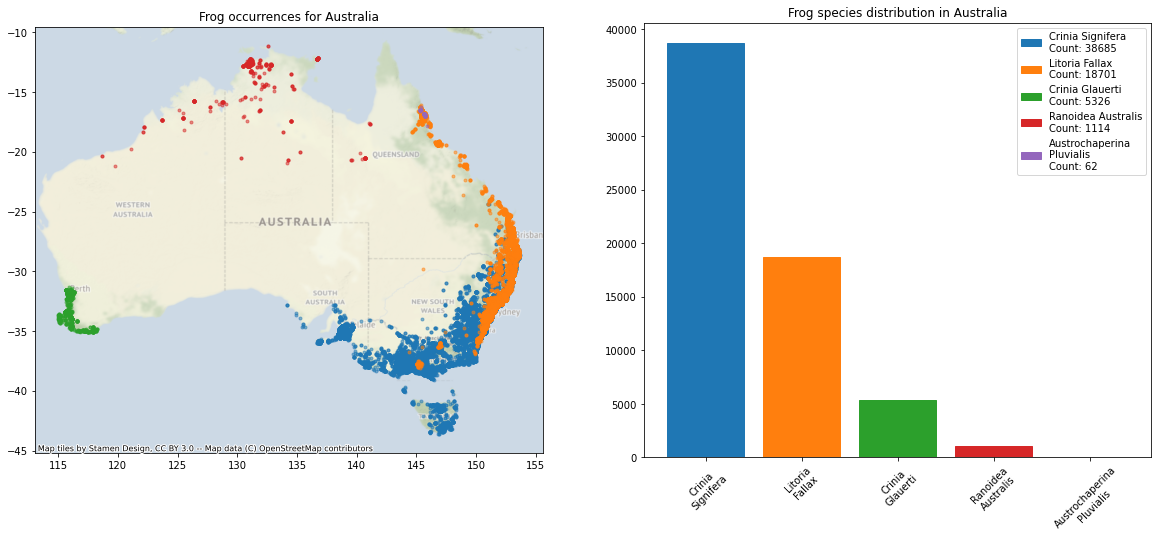

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_species(fig, ax, au_df, 'Australia')

# Litoria Fallax species in Australia from 2015 to 2019

## Find the boundary box

In [6]:
# Litoria Fallax data in Australia
lf_df = au_df[au_df['species'] == 'Litoria Fallax']
lf_df

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax
...,...,...,...,...,...,...,...,...
193484,1457334961,2017-01-23 00:00:00,Australia,Australia,New South Wales,-34.924979,150.647032,Litoria Fallax
193486,3108865868,2019-02-03 00:00:00,Australia,Australia,New South Wales,-34.028797,151.225626,Litoria Fallax
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax
193510,2981077059,2018-11-22 03:59:00,Australia,Australia,New South Wales,-34.791600,150.779300,Litoria Fallax


In [7]:
min_lat = lf_df['decimalLatitude'].min()
max_lat = lf_df['decimalLatitude'].max()
min_lon = lf_df['decimalLongitude'].min()
max_lon = lf_df['decimalLongitude'].max()

bbox = (min_lon, min_lat, max_lon, max_lat)
print(bbox)

(144.35052, -38.12691, 153.614, -16.048582)


## Plot Litoria Fallax species in Australia from 2015 to 2019

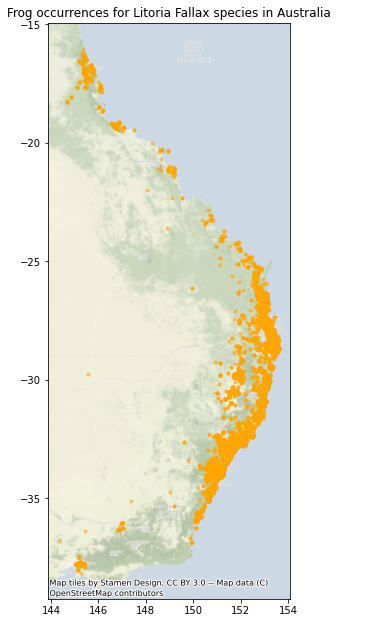

In [8]:
fig = plt.figure(figsize=(20, 8))
ax  = fig.add_axes([0,0,1,1])

# Scatter plot
ax.scatter(lf_df.decimalLongitude, 
           lf_df.decimalLatitude, 
           marker='.',
           color = 'orange',
           **{'alpha':0.5})

# Add other features
ax.set_title(f"Frog occurrences for Litoria Fallax species in Australia")
cx.add_basemap(ax, crs={'init':'epsg:4326'}, **{'alpha':0.5}) # Add basemap

#### Sampling bias

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success in this challenge.

One method of addressing the sampling bias inherent in the database is to use the occurrence points of other species as absence points for the target species. This is called pseudo-absence and is a common technique in species distribution modelling. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.

For this notebook, we will use the other species, crinia signifera - the common eastern froglet, as examples of litoria fallax's absence. We will alter our response variable to be `occurenceStatus` which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax (i.e. is crinia signifera).

In [9]:
# Create occurenceStatus column for frog data in Australia within the boundary box
au_df = au_df[lambda x: 
        (x.decimalLongitude >= min_lon) &
        (x.decimalLatitude >= min_lat) &
        (x.decimalLongitude <= max_lon) &
        (x.decimalLatitude <= max_lat)]

au_df = au_df.assign(occurrenceStatus = lambda x: np.where(x.species == 'Litoria Fallax', 1, 0))
au_df

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax,1
193510,2981077059,2018-11-22 03:59:00,Australia,Australia,New South Wales,-34.791600,150.779300,Litoria Fallax,1
193515,2573827842,2019-04-22 18:11:00,Australia,Australia,Queensland,-27.497691,153.018211,Litoria Fallax,1
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera,0


## Plot frog data in Australia within the boundary box

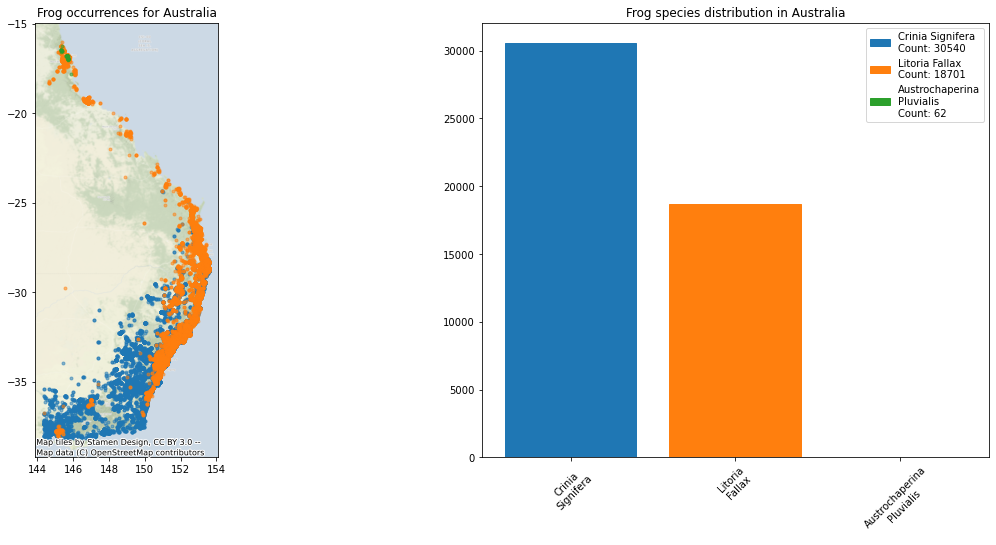

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_species(fig, ax, au_df, 'Australia')

## Save data

In [11]:
au_df.to_csv('target_data.csv', index=False)

# II. TerraClimate Dataset

### Define the analysis region and view on a map

First, we define our area of interest using latitude and longitude coordinates. Our test region is Greater Sydney, NSW, Australia. The first line defines the lower-left corner of the bounding box and the second line defines the upper-right corner of the bounding box. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates.

In [12]:
def _degree_to_zoom_level(l1, l2, margin = 0.0):
    
    degree = abs(l1 - l2) * (1 + margin)
    zoom_level_int = 0
    if degree != 0:
        zoom_level_float = math.log(360/degree)/math.log(2)
        zoom_level_int = int(zoom_level_float)
    else:
        zoom_level_int = 18
    return zoom_level_int

def display_map(latitude = None, longitude = None):
    margin = -0.5
    zoom_bias = 0
    lat_zoom_level = _degree_to_zoom_level(margin = margin, *latitude ) + zoom_bias
    lon_zoom_level = _degree_to_zoom_level(margin = margin, *longitude) + zoom_bias
    zoom_level = min(lat_zoom_level, lon_zoom_level) 
    center = [np.mean(latitude), np.mean(longitude)]
    
    map_hybrid = folium.Map(location=center,zoom_start=zoom_level, 
        tiles=" http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",attr="Google")
    
    line_segments = [(latitude[0],longitude[0]),(latitude[0],longitude[1]),
                     (latitude[1],longitude[1]),(latitude[1],longitude[0]),
                     (latitude[0],longitude[0])]
    
    map_hybrid.add_child(folium.features.PolyLine(locations=line_segments,color='red',opacity=0.8))
    map_hybrid.add_child(folium.features.LatLngPopup())        

    return map_hybrid

In [13]:
# Plot bounding box on a map
bbox = (min_lon, min_lat, max_lon, max_lat)
latitude = (min_lat, max_lat)
longitude = (min_lon, max_lon)

f = folium.Figure(width=600, height=600)
m = display_map(latitude,longitude)
f.add_child(m)

## Accessing the TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from four assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).

In [14]:
# Load the data for analysis
collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")     
asset = collection.assets["zarr-https"]
store = fsspec.get_mapper(asset.href)
weather_data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

In [15]:
weather_data = weather_data
               .sel(lon=slice(min_lon,max_lon),             # Select datapoints that overlap the boundary box of Litoria Fallax species
                    lat=slice(max_lat,min_lat),
                    time=slice('2015-01-01','2019-12-31'))
               [['aet','def','pdsi','pet','ppt','q','soil','srad','swe','tmax','tmin','vap','vpd','ws']]
               .rename(lat='y', lon='x')
               .to_array().compute()

In [16]:
# Calculate 3 metrics for 4 chosen columns
combined_values = []
combined_bands = []

metrics = {'mean':{'fn':np.nanmean,'params':{}},
            'min':{'fn':np.nanmin,'params':{}},
            'max':{'fn':np.nanmax, 'params':{}}}

for name, metric in metrics.items():
    sum_data = xr.apply_ufunc(metric['fn'], weather_data, input_core_dims=[["time"]], kwargs=metric['params'], 
                              dask = 'allowed', vectorize = True).rename(variable='band')
    xcoords = sum_data.x
    ycoords = sum_data.y
    dims = sum_data.dims
    combined_values.append(sum_data.values)
    for band in sum_data.band.values:
        combined_bands.append(band+'_'+name)

# Combine metrics
combined_values = np.concatenate(combined_values, axis=0)
weather_data = xr.DataArray(data=combined_values,
                             dims=dims,
                             coords=dict(band=combined_bands,
                                         y=ycoords,
                                         x=xcoords))    

# Take relevant bands:
weather_data = weather_data
              .sel(band=['aet_mean','def_mean','pdsi_mean','pet_mean','ppt_mean','q_mean','soil_mean',
                         'srad_mean','swe_mean','tmax_mean','tmin_mean','vap_mean','vpd_mean','ws_mean'])

In [17]:
# Interpolate values to a 512x1024 image
interp_dims = (512, 1024)
interp_coords = (np.linspace(min_lon, max_lon, interp_dims[0]), 
                 np.linspace(min_lat, max_lat, interp_dims[1]))

weather_data = weather_data.interp(x=interp_coords[0], y=interp_coords[1],
                                   method='nearest', kwargs={"fill_value": "extrapolate"})

In [18]:
print(weather_data)

<xarray.DataArray (band: 14, y: 1024, x: 512)>
array([[[36.4       , 36.4       , 35.23333333, ...,         nan,
                 nan,         nan],
        [36.4       , 36.4       , 35.23333333, ...,         nan,
                 nan,         nan],
        [36.4       , 36.4       , 35.23333333, ...,         nan,
                 nan,         nan],
        ...,
        [65.45      , 65.45      , 65.25      , ...,         nan,
                 nan,         nan],
        [65.36666667, 65.36666667, 65.71666667, ...,         nan,
                 nan,         nan],
        [65.36666667, 65.36666667, 65.71666667, ...,         nan,
                 nan,         nan]],

       [[76.75      , 76.75      , 78.13333333, ...,         nan,
                 nan,         nan],
        [76.75      , 76.75      , 78.13333333, ...,         nan,
                 nan,         nan],
        [76.75      , 76.75      , 78.13333333, ...,         nan,
                 nan,         nan],
...
        [ 1.5619

### Visualising the TerraClimate Data

The spatial distribution of the 14 variables are displayed below.

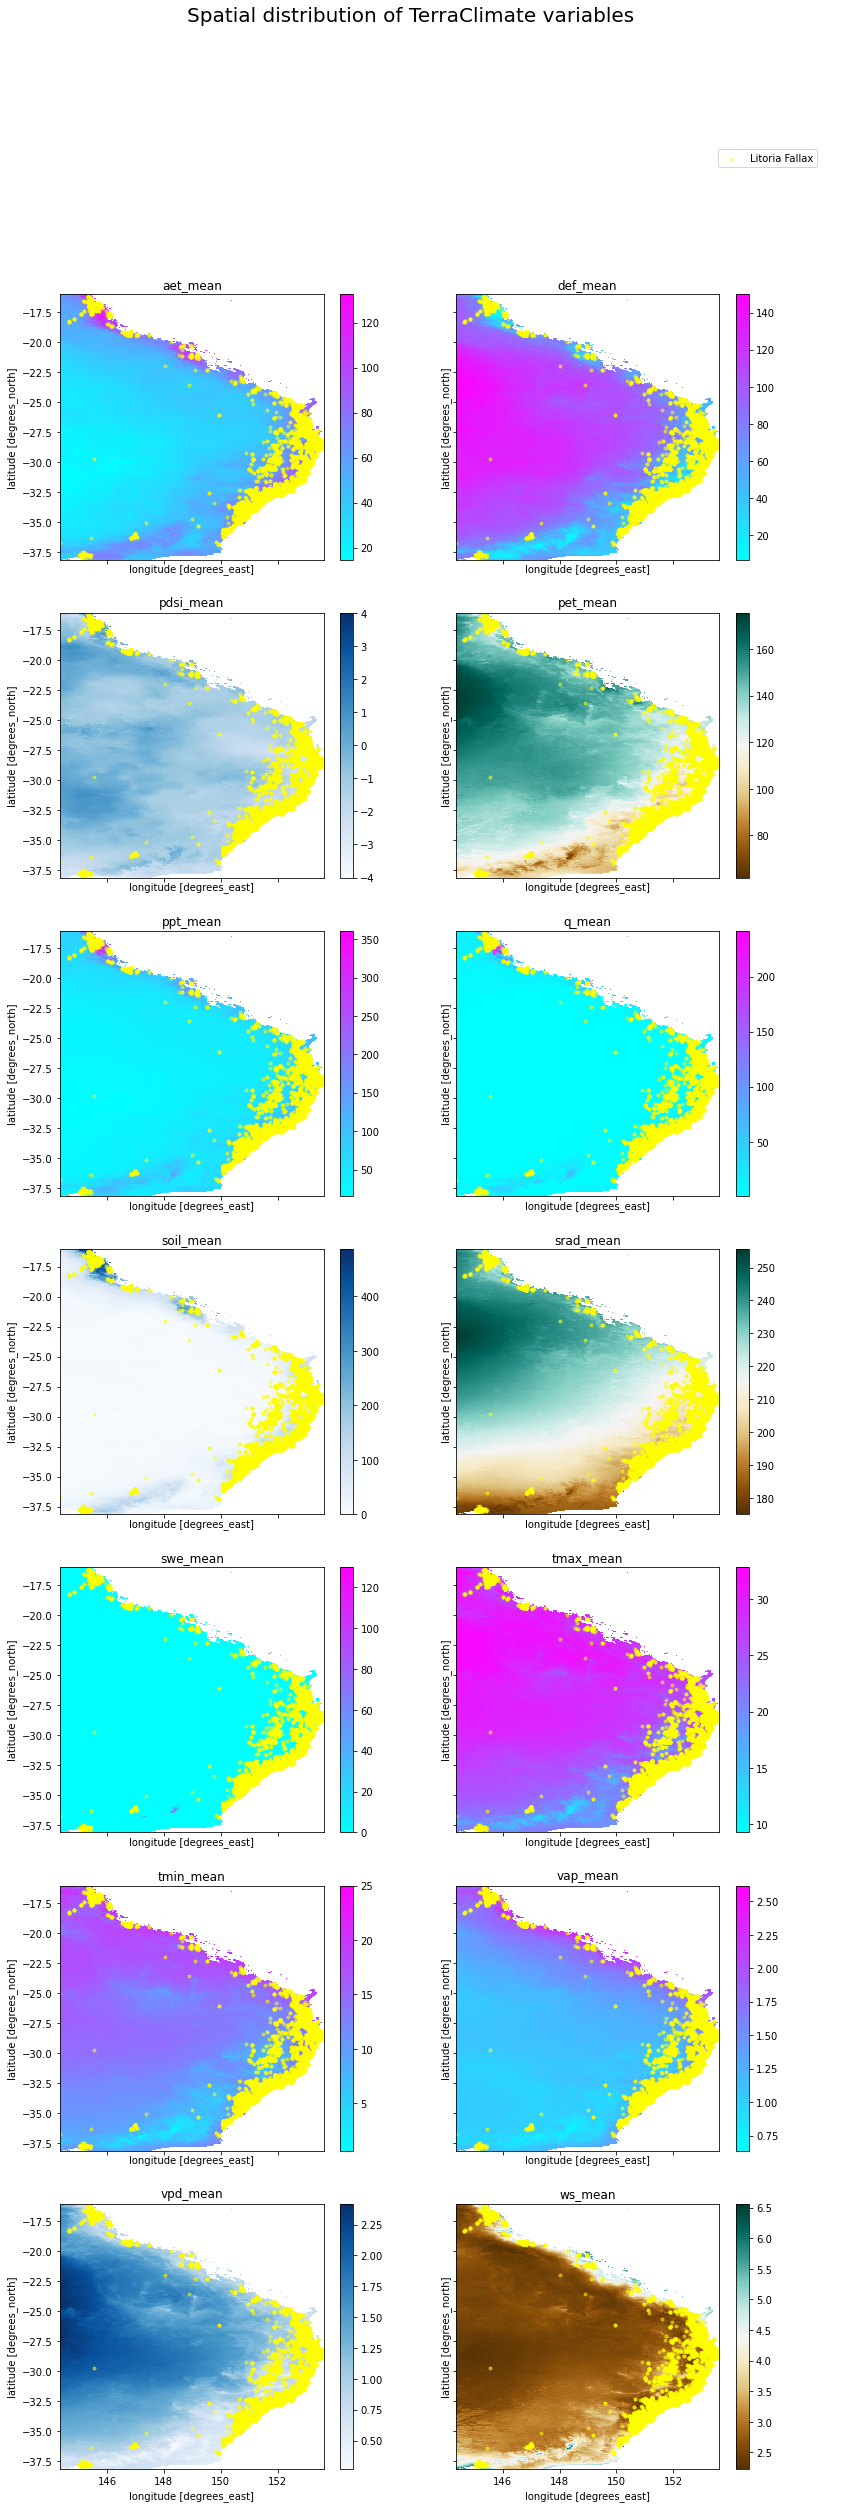

In [19]:
fig, ax = plt.subplots(7, 2, figsize=(13, 40), sharex=True, sharey=True)

bands = weather_data.band.values
filt = au_df.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG","cool", "cool", "Blues", "BrBG","cool", "cool","cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//2, i%2]) 
    ax[i//2, i%2].set_title(bands[i])
    ax[i//2, i%2].scatter(au_df[filt].decimalLongitude, au_df[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, 
                                label='Litoria Fallax' if i==0 else '')

fig.suptitle("Spatial distribution of TerraClimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

## Feature engineering

The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model you decide to train, some of the variables might require normalisation, standardisation, or transformation. For now, we will proceed with the variables as they come.

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

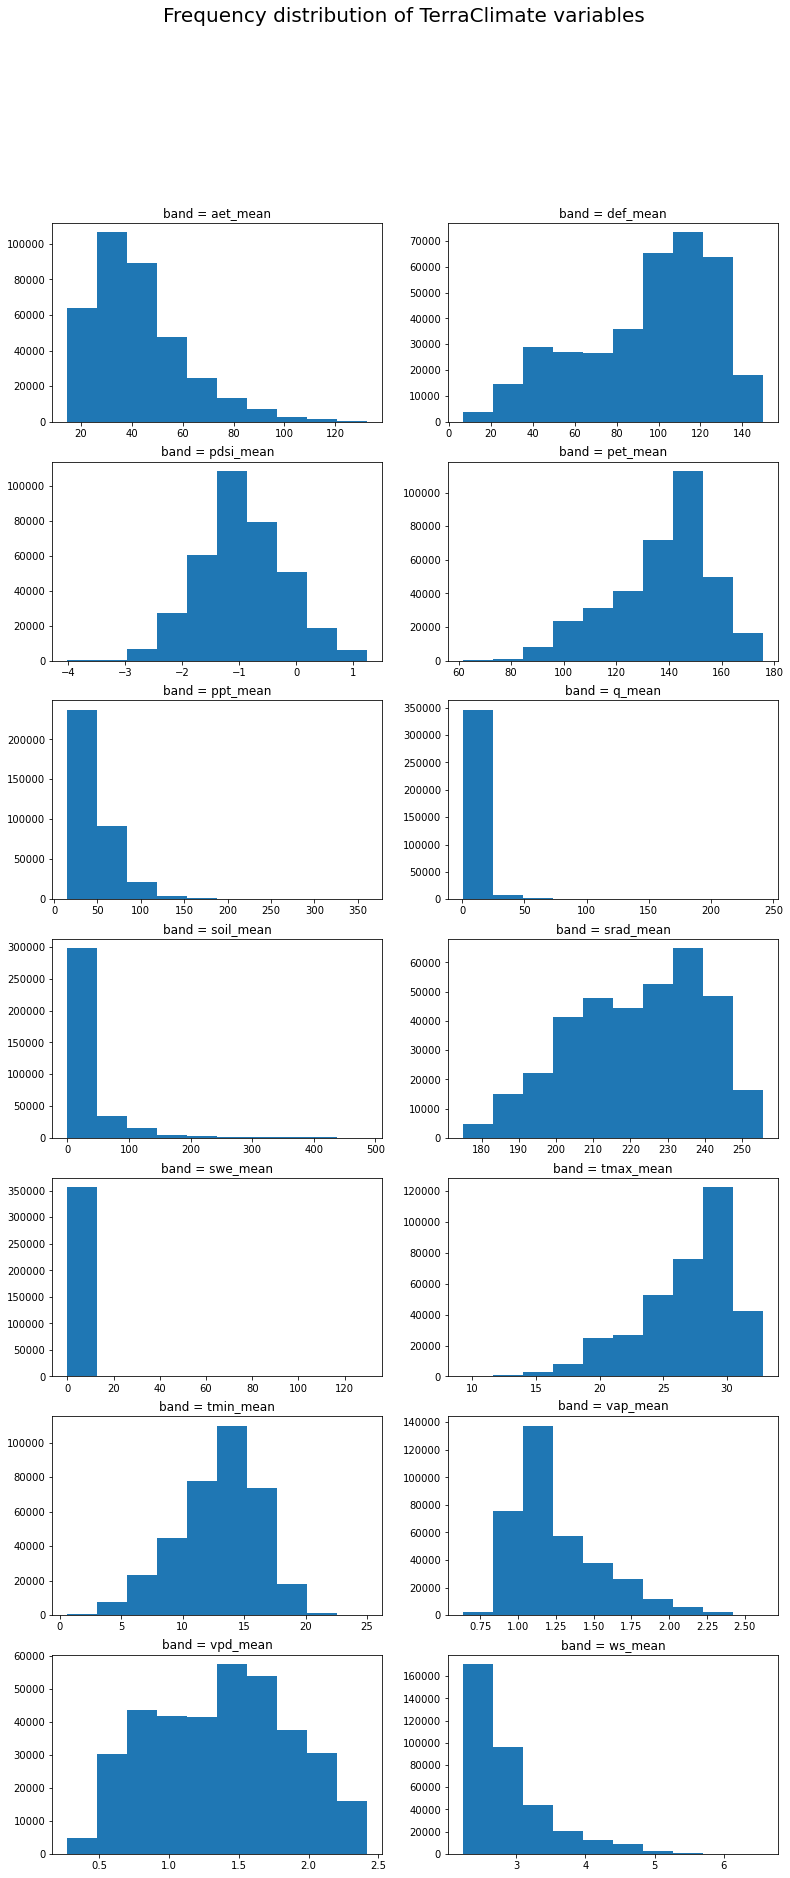

In [20]:
fig, ax = plt.subplots(7, 2, figsize=(13, 30))

bands = weather_data.band.values
for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//2, i%2])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

### Joining weather data to the species data

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [21]:
au_df['key'] = au_df.index

In [22]:
weather_data = weather_data
               .rename('data')
               .sel(x=xr.DataArray(au_df.decimalLongitude, dims="key", coords={"key": au_df.index}), 
                    y=xr.DataArray(au_df.decimalLatitude, dims="key", coords={"key": au_df.index}),
                    method="nearest")
               .to_dataframe()
               .assign(val = lambda x: x.iloc[:, -1])
                [['val']]
               .reset_index()
               .drop_duplicates()
               .pivot(index="key", columns="band", values="val")
               .reset_index()

In [23]:
model_data = au_df.merge(weather_data, on = "key", how = 'inner')
model_data.drop(['key','gbifID','eventDate','country', 'continent','stateProvince','species'], axis = 1, inplace = True)
model_data.head()

,decimalLatitude,decimalLongitude,occurrenceStatus,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,q_mean,soil_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,-33.693144,151.320884,1,83.600000,34.233333,-1.655000,117.783333,97.766667,14.366667,75.566667,196.116667,0.0,23.578335,13.778335,1.451000,0.716833,4.141667
1,-33.925746,151.164082,1,79.783333,40.133333,-1.598333,119.933333,89.583333,9.933333,80.833333,191.533333,0.0,23.538335,14.068335,1.435667,0.755167,4.315000
2,-31.732415,152.088515,1,82.150000,30.433333,-2.233333,112.600000,91.600000,10.333333,95.583333,201.816667,0.0,23.356668,10.981668,1.253167,0.769500,2.875000
3,-32.968624,151.644194,1,75.250000,45.200000,-2.108333,120.466667,84.133333,8.866667,73.650000,199.816667,0.0,23.895002,13.938335,1.473000,0.737833,4.123333
4,-33.093048,151.416300,1,72.933333,42.833333,-2.015000,115.683333,81.216667,8.550000,61.833333,198.766667,0.0,23.756668,13.061669,1.433333,0.724333,3.653333


In [24]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49303 entries, 0 to 49302
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   decimalLatitude   49303 non-null  float64
 1   decimalLongitude  49303 non-null  float64
 2   occurrenceStatus  49303 non-null  int64  
 3   aet_mean          49258 non-null  float64
 4   def_mean          49258 non-null  float64
 5   pdsi_mean         49258 non-null  float64
 6   pet_mean          49258 non-null  float64
 7   ppt_mean          49258 non-null  float64
 8   q_mean            49258 non-null  float64
 9   soil_mean         49258 non-null  float64
 10  srad_mean         49258 non-null  float64
 11  swe_mean          49258 non-null  float64
 12  tmax_mean         49258 non-null  float64
 13  tmin_mean         49258 non-null  float64
 14  vap_mean          49258 non-null  float64
 15  vpd_mean          49258 non-null  float64
 16  ws_mean           49258 non-null  float6

## Save data

In [25]:
model_data.to_csv('model_data.csv', index=False)